[My last blogpost](https://mlops.systems/posts/2023-03-05-stable-eights-adversarial.html) was about my attempt to try to generate images of handwritten 'eight' digits from random noise. It was an exploration of some of the process at work in diffusion models and the whole diffusion paradigm in general.

It's come up since then during our Sunday morning ['Delft FastAI Study Group'](https://www.meetup.com/delft-fast-ai-study-group/) sessions and we've been throwing around a few different ideas on how to improve the process to actually output eights. Two in particular seemed like things we'd want to try out:

1) Perceptual Loss
2) Siamese Networks

I thought I'd try to implement a starter version of both of these in order to learn what they are, and in order to present for our group discussion. Before we get started, we can get some boilerplate setup out of the way (i.e. the status quo by the end of the last post).

## 1: Training an '8' digit classifier (initial / naive approach)

In [69]:
#| code-fold: true
!pip install -Uqq pip
!pip install fastai torch datasets rich -Uqq
# !pip install -Uqq timm

import IPython

# automatically restart kernel
IPython.Application.instance().kernel.do_shutdown(restart=True)

^C
ERROR: Operation cancelled by user


{'status': 'ok', 'restart': True}

: 

In [1]:
# | code-fold: true
from typing import Union, Callable

from fastai.vision.all import *
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.models import vgg19
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt


# make sure the digits are human-readable
torch.set_printoptions(precision=6, sci_mode=False)

# dataset patched together from the original MNIST dataset
path = Path("./mnist_8_or_not/training")
fnames = get_image_files(path)


def label_func(x):
    return x.parent.name


dls = ImageDataLoaders.from_path_func(path, fnames, label_func)
# set environment based on hostname
import os

environment_type = "unknown"

if "HOSTNAME" in os.environ:
    hostname = os.environ["HOSTNAME"]
    environment_type = "local" if hostname == "localhost" else "cloud"

model_filename = "eight_classifier.pkl"
model_base_path = Path("/home/") if environment_type == "cloud" else Path("./")

# only train the model if we have no model already
model_path = Path(f"{model_base_path}/{model_filename}")

if not model_path.exists():
    learn = vision_learner(dls, resnet34, metrics=error_rate)
    learn.fine_tune(6)
    # export our model so we don't have to retrain it every time from now on
    learn.export(f"{model_base_path}{model_filename}")
else:
    learn = load_learner(f"{model_base_path}/{model_filename}")
an_eight = Path(path / "8").ls()[0]
not_an_eight = Path(path / "not_8").ls()[0]


def get_eight_probability(
    image_pth: Union[Path, torch.Tensor], learner: Learner
) -> torch.Tensor:
    _, _, probs = learner.predict(image_pth)
    return probs[0]


/Users/strickvl/.pyenv/versions/3.10.4/envs/mlops-blog/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# we generate a 3x28x28 tensor with random values assigned
# we ensure that we can use PyTorch's autograd on the values
def get_noisy_starter_tensor() -> torch.Tensor:
    return torch.randn(3, 28, 28, requires_grad=True)


# this will allow us to display the tensor as an image
def display_tensor(tns: torch.Tensor):
    # Convert the tensor to a NumPy array
    image_array = tns.detach().numpy()

    # Clip the pixel values between 0 and 1
    image_array = np.clip(image_array, 0, 1)

    # Transpose the array to (28, 28, 3) shape
    image_array = image_array.transpose((1, 2, 0))

    # Display the image using Matplotlib
    plt.imshow(image_array)
    plt.show()


# Using Perceptual Loss

I didn't really have much of a sense of what perceptual loss was going into
this, except that it was a loss function that was used in style transfer
and that it was a way to measure the difference between two images.

Specifically, you have to define a 'feature extractor' that takes an image
and returns a set of features. The loss is then the difference between
the features of the generated image and the features of the target image.
Implicit in this is that you are using some pre-trained model to extract the
features. For our purposes, I started out my experiments with `resnet18` but
then switched over to `vgg19` after reading a bit more

Perceptual loss, also known as content or feature loss, is a technique used to measure the similarity between two images at a higher, more perceptual level rather than pixel-by-pixel. It is particularly useful in tasks like style transfer, where the goal is to generate an image that combines the content of one image with the style of another.

The basic idea behind perceptual loss is to extract high-level features from both the generated and target images using a pre-trained deep learning model, often a convolutional neural network (CNN). The loss is then calculated as the difference between the extracted features, rather than the raw pixel values.

A feature extractor is a deep learning model that processes an image and outputs a set of features that capture meaningful information about the content of the image. These features can be thought of as a condensed representation of the image, which encodes its essential characteristics.

To compute perceptual loss, we start by passing both the generated and target
images through a pre-trained CNN, such as ResNet-18 or VGG-19. These networks
are trained on large-scale image classification tasks and are already capable of
extracting high-level features that represent the content of the images.

Once the features are extracted, we compute the loss as the difference between the features of the generated image and the features of the target image. This difference can be calculated using various metrics, such as the mean squared error (MSE) or the L1-norm.

The main advantage of perceptual loss is that it is less sensitive to small,
local changes in pixel values and focuses more on the overall content of the
images. This makes it well-suited for tasks like style transfer, where the
objective is to preserve the content of the input image while applying the style
of another image. By using a pre-trained feature extractor like VGG-19 the loss
function can leverage the knowledge learned from a vast amount of image data to
better capture and compare the perceptual content of the images.


The code below includes my implementation of the perceptual loss function as
well as an `vgg__iterate_image` function that I used to iterate over the image
we're generating.

In [3]:
def perceptual_loss(feature_extractor, generated_image, target_image):
    gen_features = feature_extractor(generated_image)
    target_features = feature_extractor(target_image)
    loss = nn.functional.l1_loss(gen_features, target_features)
    return loss


def vgg_iterate_image(
    image: torch.Tensor,
    target_image: torch.Tensor,
    iota: int,
    update_rate: float = 0.1,
    update_printout: int = 5,
    no_image: bool = False,
):
    # Load the pre-trained VGG model
    vgg = vgg19(pretrained=True).features.eval()
    for param in vgg.parameters():
        param.requires_grad = False

    # Choose a specific layer for the perceptual loss (e.g., 8th layer)
    feature_extractor = nn.Sequential(*list(vgg.children())[:9])

    image.requires_grad_()

    # Calculate perceptual loss
    loss = perceptual_loss(feature_extractor, image[None], target_image[None])
    loss.backward()

    if iota % update_printout == 0:
        print(f"iter {iota} / grad_sum: {image.grad.data.sum()}, loss: {loss}")

    image.data -= update_rate * image.grad.data
    image.grad.zero_()

    if not no_image and iota % update_printout == 0:
        # N.B. Use v1 to get a sense of what's changing, v2 for the current values

        # VERSION 1
        # plt.imshow(np.log1p(image[0].detach().numpy()))
        # plt.show(plt.gcf())

        # VERSION 2
        display_tensor(image)


I also implemented a version for `resnet` but that didn't work as well or
converge as quickly as `vgg19` so I'm just including the code for posterity here.

In [4]:
#| code-fold: true
def perceptual_loss(feature_extractor, generated_image, target_image):
    gen_features = feature_extractor(generated_image)
    target_features = feature_extractor(target_image)
    loss = nn.functional.l1_loss(gen_features, target_features)
    return loss


def resnet_iterate_image(
    image: torch.Tensor,
    target_image: torch.Tensor,
    iota: int,
    update_rate: float = 0.1,
    update_printout: int = 5,
    no_image: bool = False,
):
    # Load the pre-trained ResNet model
    resnet = resnet18(pretrained=True)  # Load the pre-trained ResNet-18 model
    resnet = nn.Sequential(
        *list(resnet.children())[:-1]
    )  # Remove the last fully connected layer
    resnet.eval()  # Set the ResNet model to evaluation mode
    for param in resnet.parameters():
        param.requires_grad = False

    # Choose a specific layer for the perceptual loss (e.g., layer before the last fully connected layer)
    feature_extractor = resnet

    image.requires_grad_()
    preds = torch.softmax(learn.model(image[None]), dim=1)
    targets = torch.Tensor([[1.0, 0]])

    # Calculate perceptual loss
    loss = perceptual_loss(feature_extractor, image[None], target_image[None])
    loss.backward()

    if iota % update_printout == 0:
        print(f"iter {iota} / grad_sum: {image.grad.data.sum()}, loss: {loss}")

    image.data -= update_rate * image.grad.data
    image.grad.zero_()

    if not no_image and iota % update_printout == 0:
        # N.B. Use v1 to get a sense of what's changing, v2 for the current values

        # VERSION 1
        # plt.imshow(np.log1p(image[0].detach().numpy()))
        # plt.show(plt.gcf())

        # VERSION 2
        display_tensor(image)

Here we get our target image (a random one of our 'eight' digits from the
training set) and apply the same transforms to get it in the same size and
format as our random noise image.

I reversed the values of the target image so that instead of being white
squiggles on a black background, we now have black squiggles on a white
background.

In [5]:
target_image_pil = Image.open(an_eight).convert('RGB')

preprocess = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize the image to match the input dimensions (3, 28, 28)
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    # Normalize the image with mean and std (use the same mean and std as your input image preprocessing)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Apply preprocessing
target_image = preprocess(target_image_pil)

max_value = target_image.max()
reversed_target_image = max_value - target_image

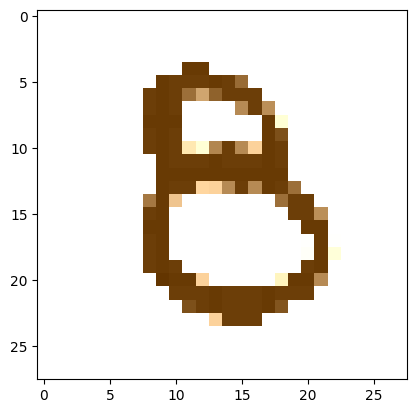

In [6]:
display_tensor(reversed_target_image)

For the iteration process, it's fairly similar to what I did in the last post,
only the number of iterations is still quite high. It prints out the image every
200 iterations so you can see it slowly converging and improving.

I had to experiment around quite a bit with the 'update_rate' (going from very
low (i.e. 0.1) all the way up to 1000 at one point). I also decided to create
the `reversed_target_image` at some point during this process because I
suspected it might give better results. Here you can see the number 8 slowly
emerging from the noise.

iter 0 / grad_sum: -0.11695463210344315, loss: 3.349287986755371


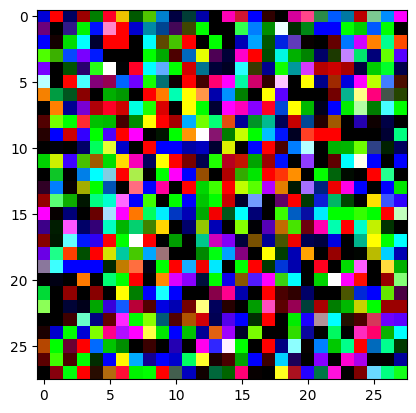

iter 200 / grad_sum: -0.05261861905455589, loss: 1.8285313844680786


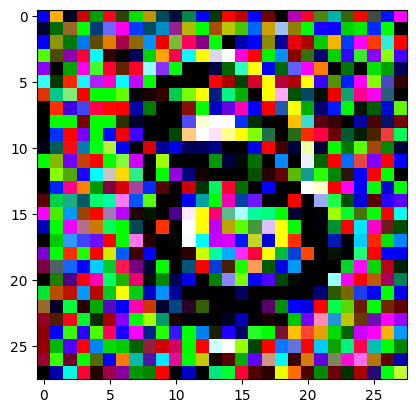

iter 400 / grad_sum: -0.05507233738899231, loss: 1.559353232383728


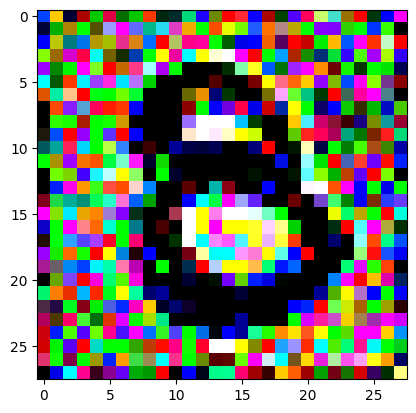

iter 600 / grad_sum: -0.08732452243566513, loss: 1.4069606065750122


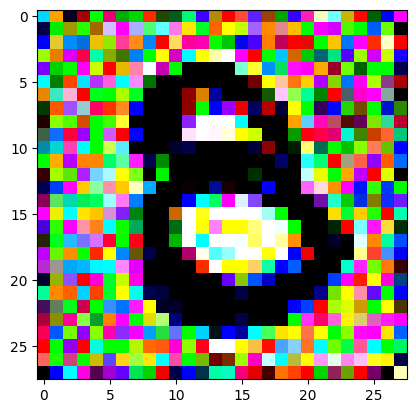

iter 800 / grad_sum: -0.11042110621929169, loss: 1.3145689964294434


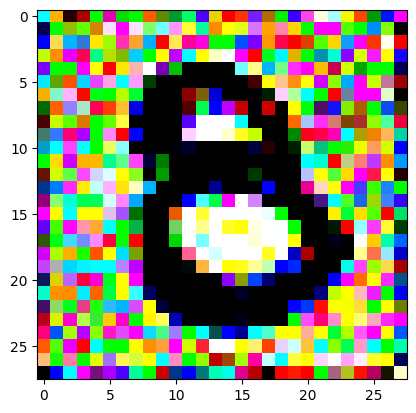

iter 1000 / grad_sum: -0.14137724041938782, loss: 1.2493029832839966


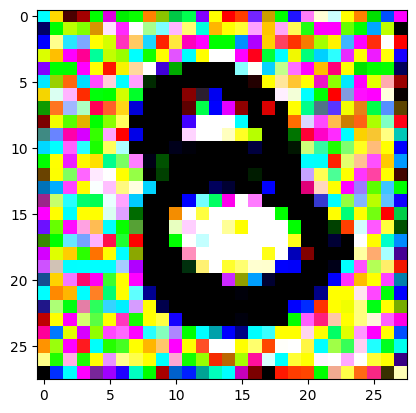

In [55]:
random_sample = get_noisy_starter_tensor()

for i in range(1200):
    vgg_iterate_image(
        random_sample,
        reversed_target_image,
        i,
        update_rate=8.0,
        update_printout=200,
    )


It took me a couple of hours to get to this point, and the inference and
time to update each iteration was pretty slow. I suspect that it might be faster
on a GPU, but I didn't have one available to me at the time.

Next time, I'll try to implement a Siamese network and see if that gives me
better results. (First will have to figure out what exactly that is and how it works!)

/Users/strickvl/.pyenv/versions/3.10.4/envs/mlops-blog/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


iter 0 / grad_sum: -0.10067621618509293, loss: 3.2533576488494873


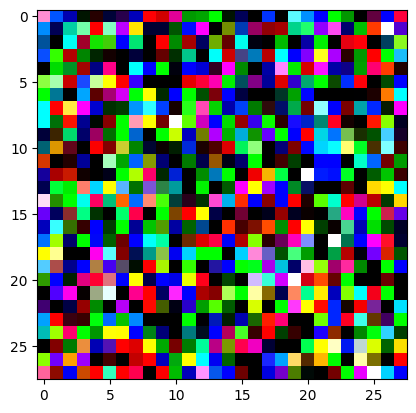

iter 200 / grad_sum: -0.05489164963364601, loss: 1.8312240839004517


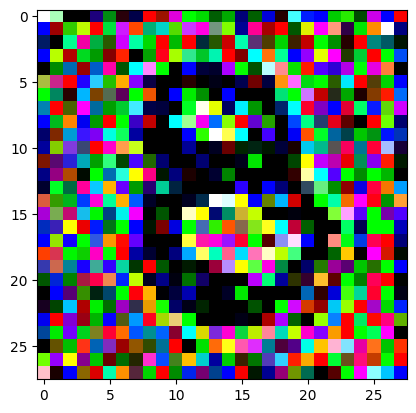

iter 400 / grad_sum: -0.054107874631881714, loss: 1.5468450784683228


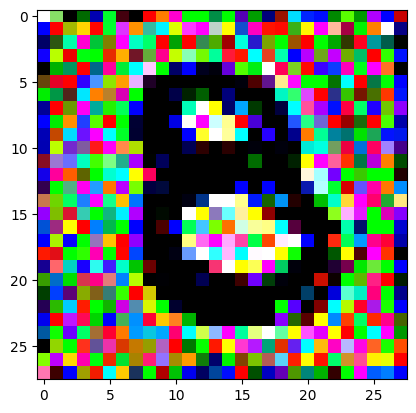

iter 600 / grad_sum: -0.07920947670936584, loss: 1.4032789468765259


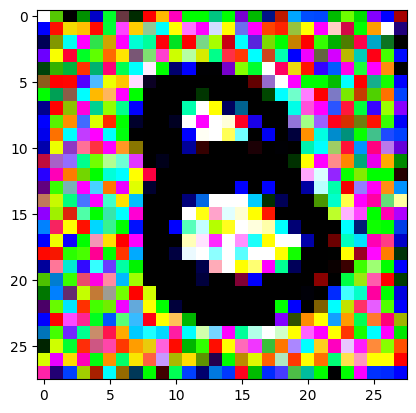

iter 800 / grad_sum: -0.11411219835281372, loss: 1.2947640419006348


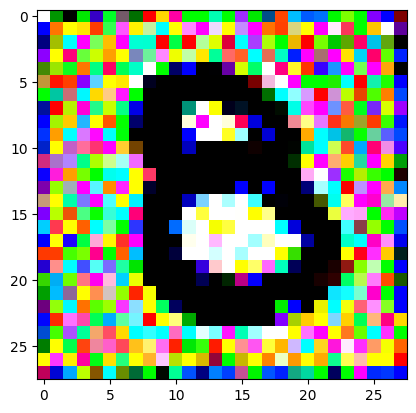

iter 1000 / grad_sum: -0.14544689655303955, loss: 1.2132982015609741


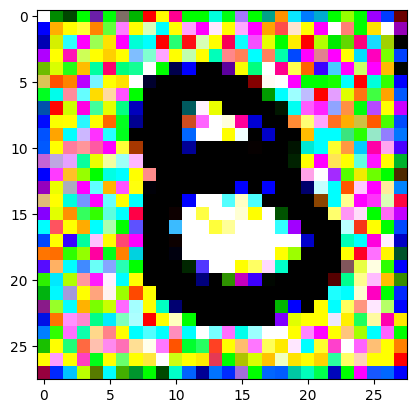

iter 1200 / grad_sum: -0.16940060257911682, loss: 1.1574007272720337


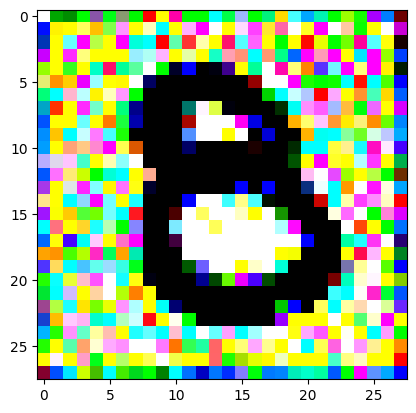

iter 1400 / grad_sum: -0.18719588220119476, loss: 1.108056664466858


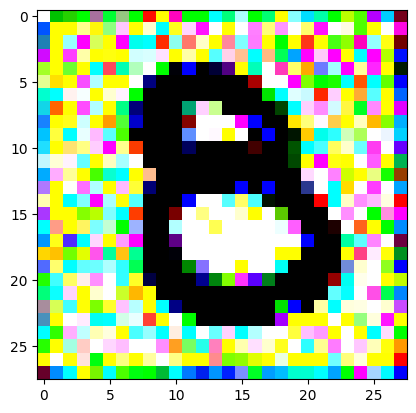

iter 1600 / grad_sum: -0.2136225700378418, loss: 1.0530391931533813


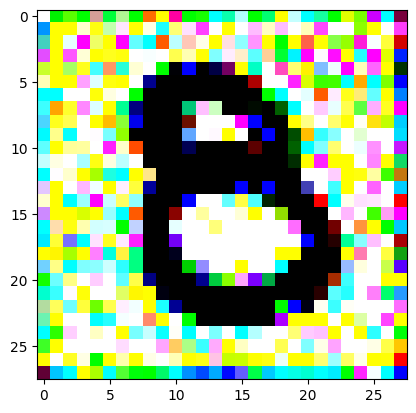

iter 1800 / grad_sum: -0.2254064530134201, loss: 0.9971842169761658


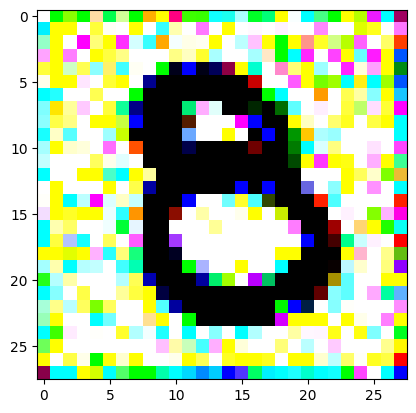

iter 2000 / grad_sum: -0.2527287006378174, loss: 0.9344728589057922


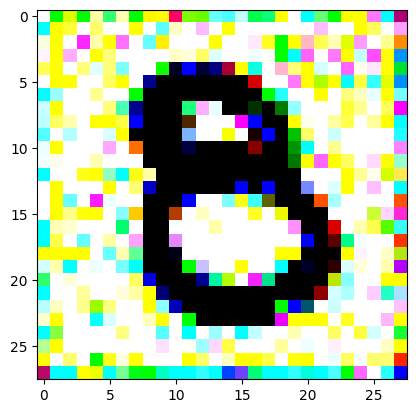

iter 2200 / grad_sum: -0.26381513476371765, loss: 0.8655626177787781


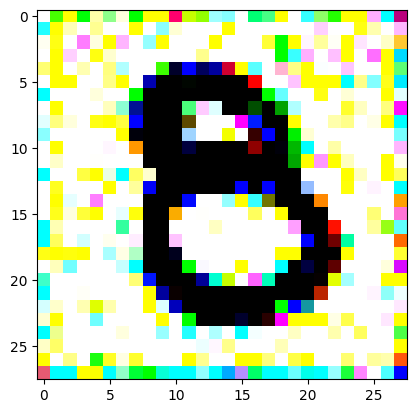

iter 2400 / grad_sum: -0.26774412393569946, loss: 0.7914406657218933


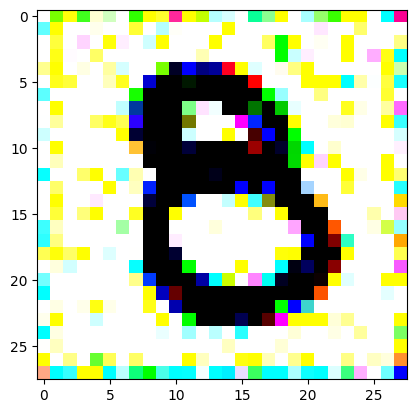

iter 2600 / grad_sum: -0.2612324655056, loss: 0.726896345615387


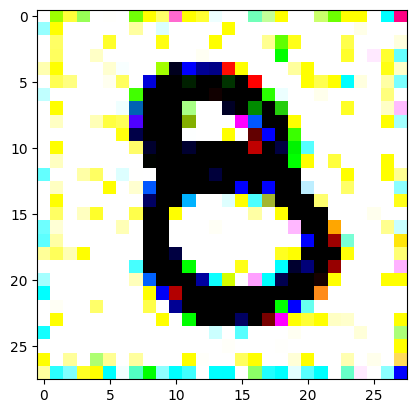

iter 2800 / grad_sum: -0.2553003430366516, loss: 0.6689462661743164


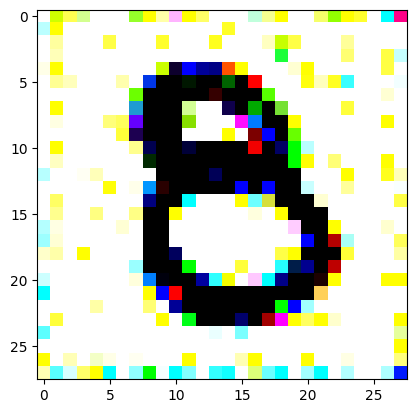

iter 3000 / grad_sum: -0.2531996965408325, loss: 0.6113003492355347


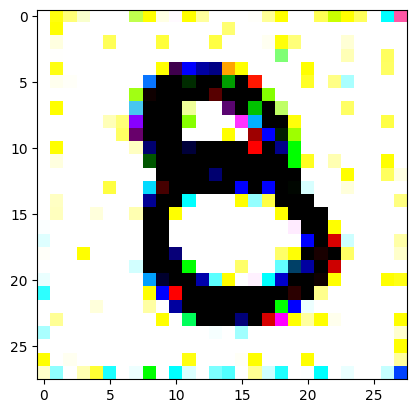

iter 3200 / grad_sum: -0.25401824712753296, loss: 0.5582084655761719


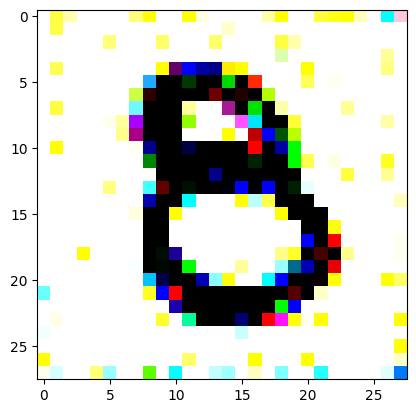

iter 3400 / grad_sum: -0.2472103387117386, loss: 0.5116526484489441


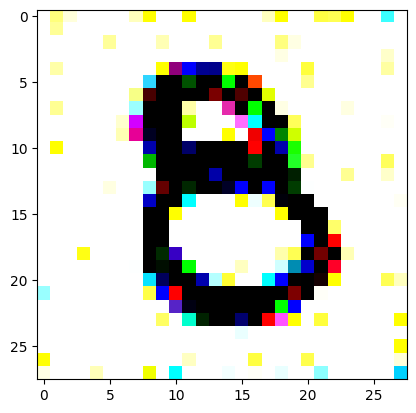

iter 3600 / grad_sum: -0.23793253302574158, loss: 0.4699331820011139


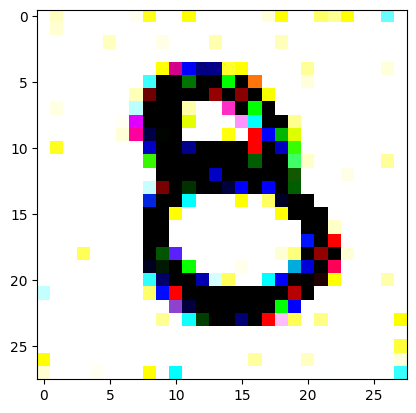

iter 3800 / grad_sum: -0.22248002886772156, loss: 0.4433839023113251


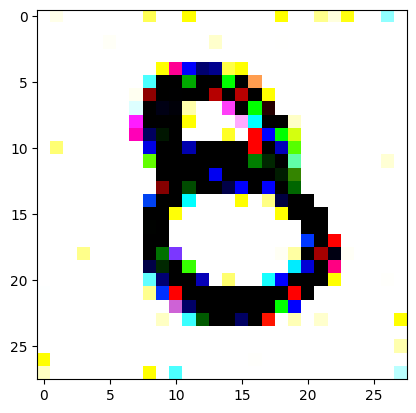

iter 4000 / grad_sum: -0.20998376607894897, loss: 0.3811723291873932


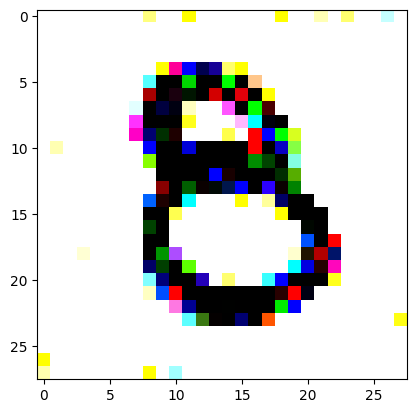

iter 4200 / grad_sum: -0.19712524116039276, loss: 0.37239381670951843


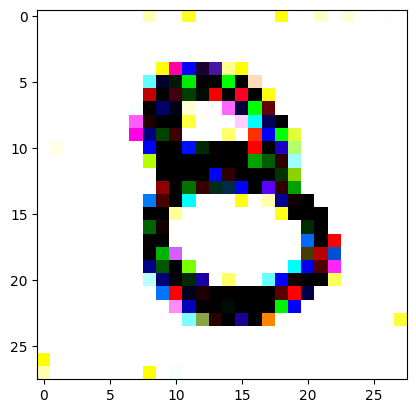

iter 4400 / grad_sum: -0.16977882385253906, loss: 0.34740307927131653


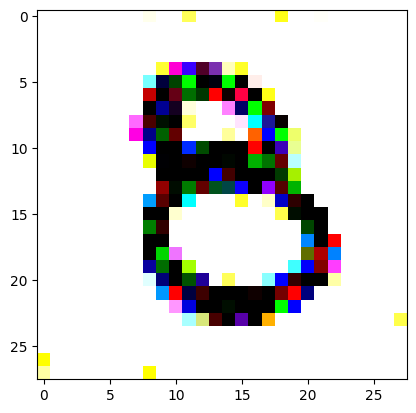

iter 4600 / grad_sum: -0.16369280219078064, loss: 0.3144417703151703


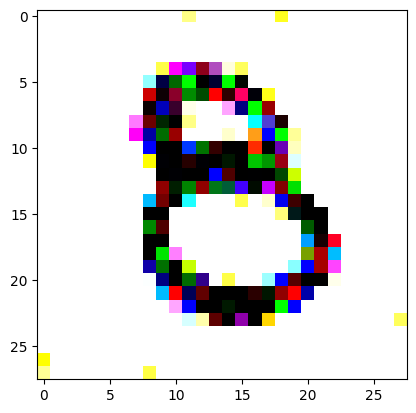

iter 4800 / grad_sum: -0.12760969996452332, loss: 0.32315561175346375


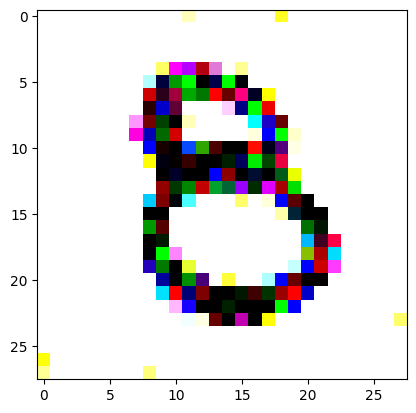

iter 5000 / grad_sum: -0.1290731281042099, loss: 0.2868266999721527


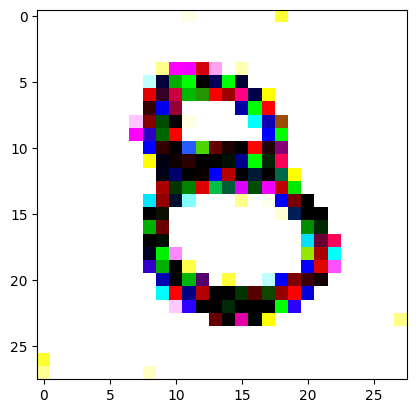

iter 5200 / grad_sum: -0.09261088073253632, loss: 0.26794564723968506


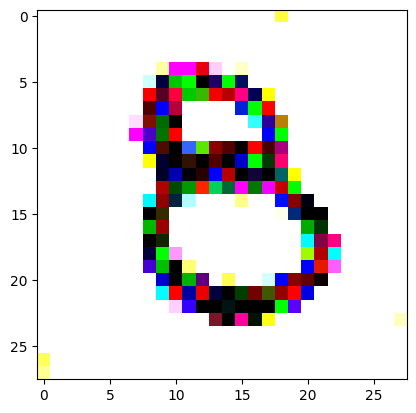

iter 5400 / grad_sum: -0.08580854535102844, loss: 0.26148849725723267


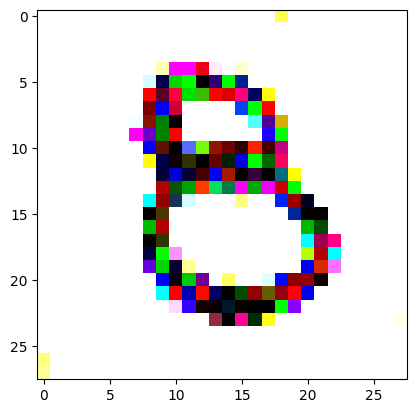

iter 5600 / grad_sum: -0.06559965014457703, loss: 0.26385462284088135


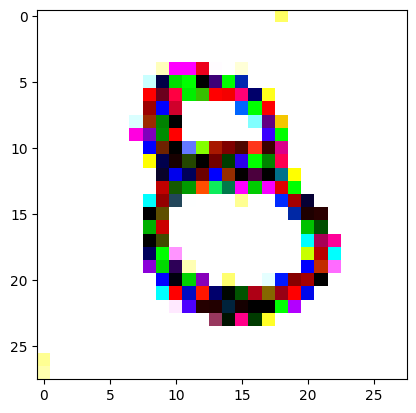

iter 5800 / grad_sum: -0.025712519884109497, loss: 0.273421049118042


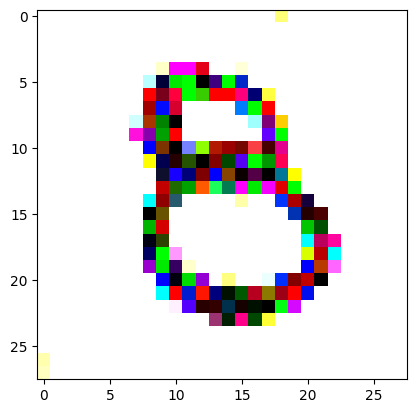

iter 6000 / grad_sum: -0.04072136431932449, loss: 0.22964514791965485


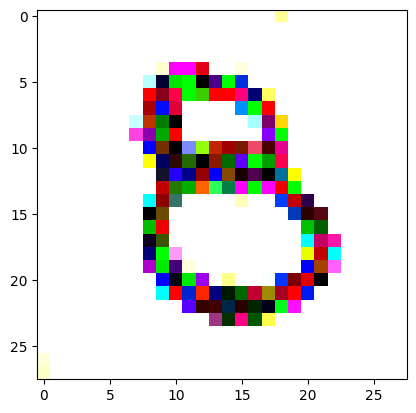

iter 6200 / grad_sum: -0.030087554827332497, loss: 0.25004929304122925


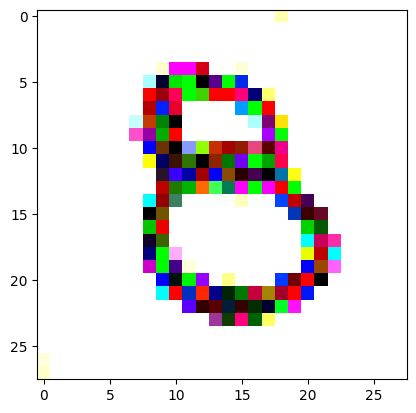

iter 6400 / grad_sum: -0.032913655042648315, loss: 0.25699320435523987


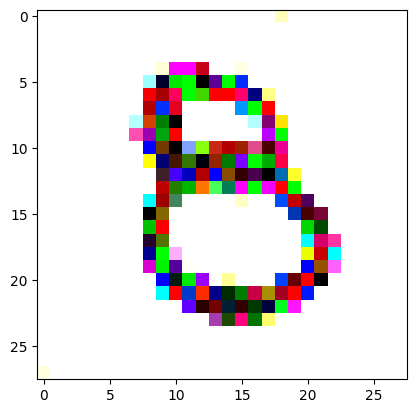

iter 6600 / grad_sum: -0.021285470575094223, loss: 0.23544834554195404


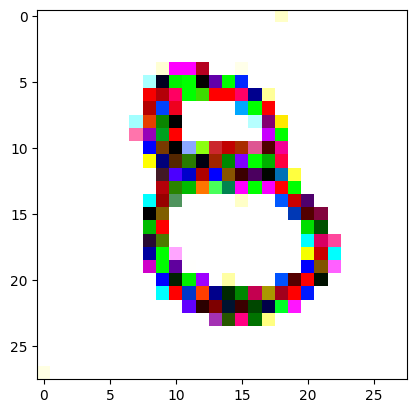

iter 6800 / grad_sum: -0.015309110283851624, loss: 0.22240281105041504


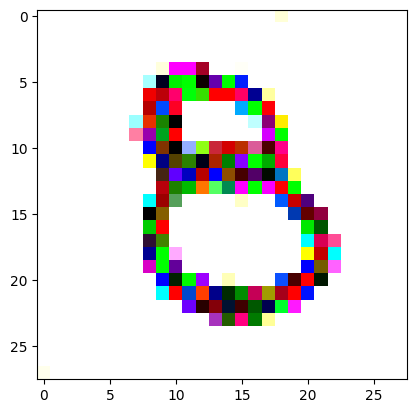

iter 7000 / grad_sum: -0.002907566726207733, loss: 0.256386399269104


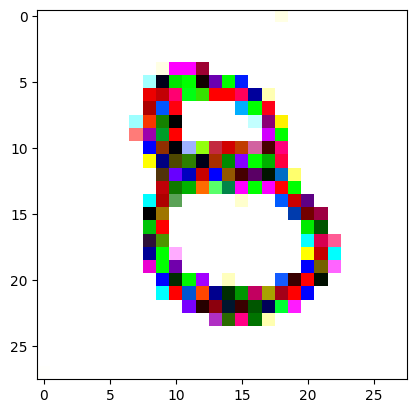

iter 7200 / grad_sum: -0.013432338833808899, loss: 0.24497221410274506


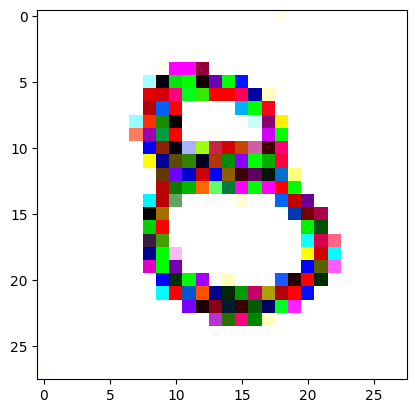

iter 7400 / grad_sum: 0.002584397792816162, loss: 0.24868912994861603


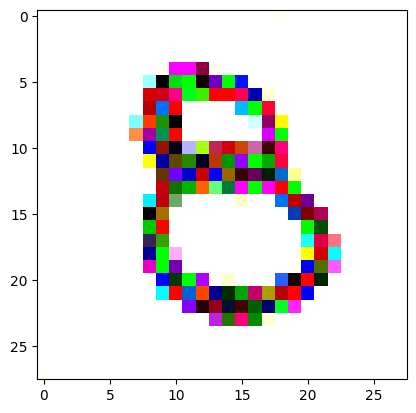

iter 7600 / grad_sum: -0.009248964488506317, loss: 0.2450336366891861


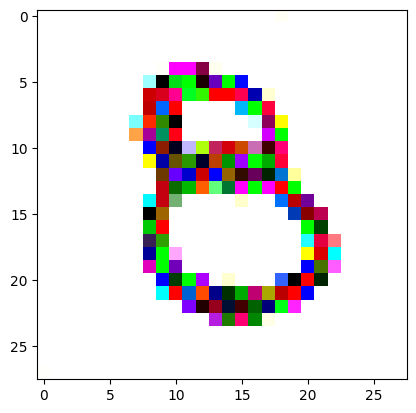

iter 7800 / grad_sum: -0.0018646717071533203, loss: 0.25336411595344543


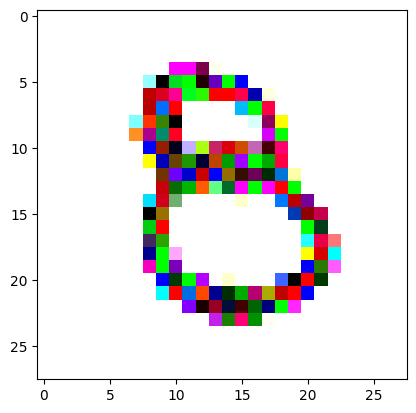

iter 8000 / grad_sum: -0.013653086498379707, loss: 0.24088498950004578


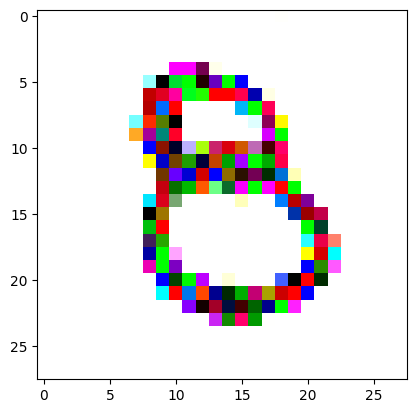

iter 8200 / grad_sum: -0.01744297333061695, loss: 0.20649825036525726


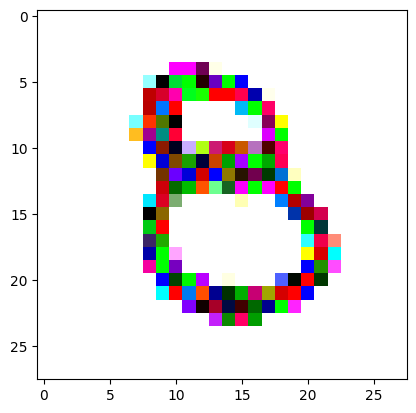

iter 8400 / grad_sum: -0.00710982084274292, loss: 0.2272096574306488


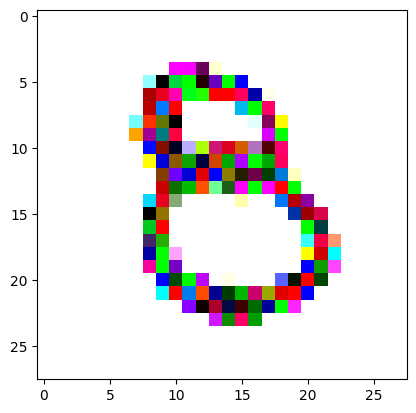

iter 8600 / grad_sum: 0.004392959177494049, loss: 0.22836482524871826


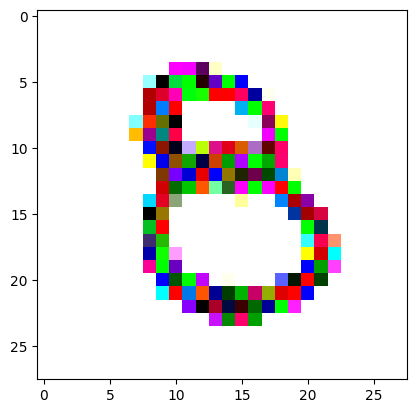

iter 8800 / grad_sum: -0.005208563059568405, loss: 0.2397071272134781


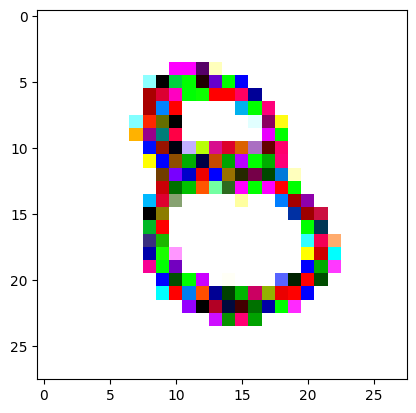

iter 9000 / grad_sum: -0.004147965461015701, loss: 0.23213578760623932


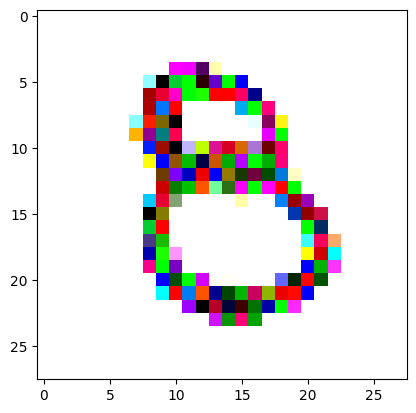

iter 9200 / grad_sum: -0.011317238211631775, loss: 0.23897279798984528


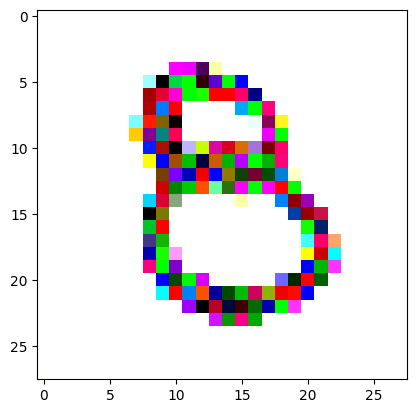

iter 9400 / grad_sum: 0.0013678669929504395, loss: 0.21524861454963684


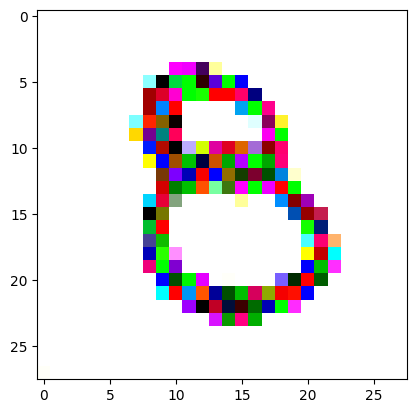

iter 9600 / grad_sum: -0.0031454861164093018, loss: 0.24317485094070435


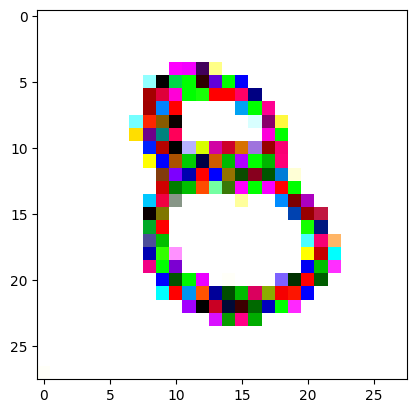

iter 9800 / grad_sum: 0.0048993900418281555, loss: 0.22074298560619354


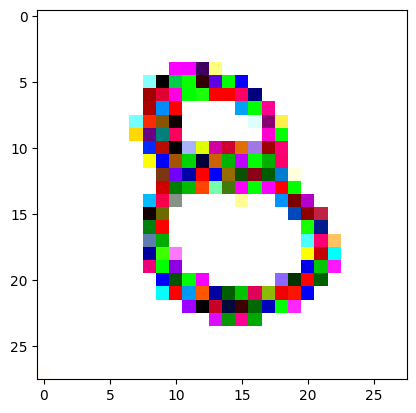

iter 10000 / grad_sum: 0.000981885939836502, loss: 0.20930485427379608


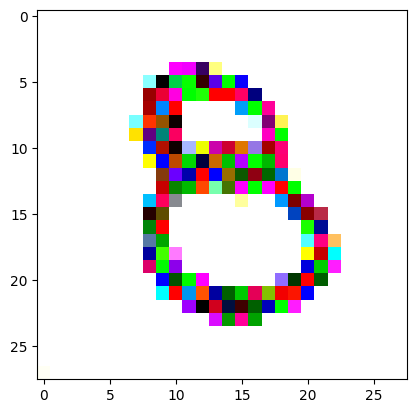

iter 10200 / grad_sum: -0.010918810963630676, loss: 0.2221449315547943


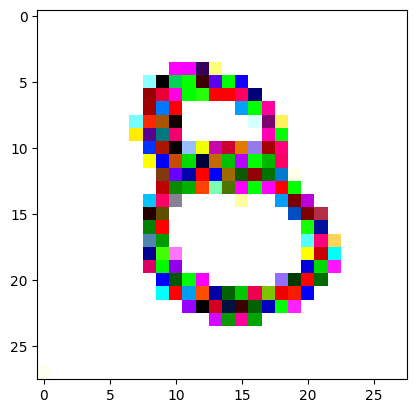

iter 10400 / grad_sum: -0.009839233011007309, loss: 0.2183818370103836


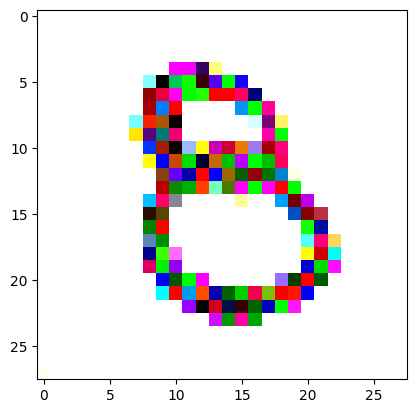

iter 10600 / grad_sum: 0.007621109485626221, loss: 0.21323300898075104


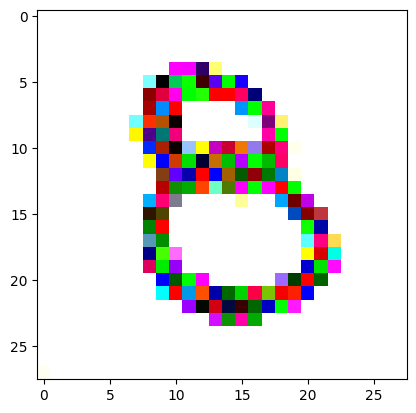

iter 10800 / grad_sum: 0.004075892269611359, loss: 0.2392408847808838


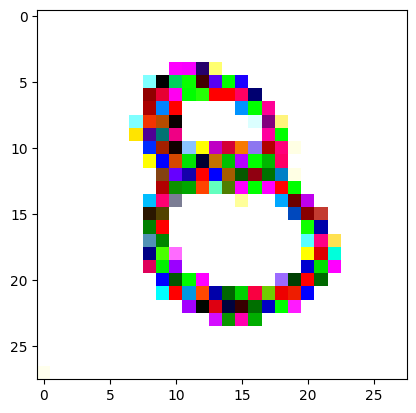

iter 11000 / grad_sum: 0.0029926151037216187, loss: 0.22209693491458893


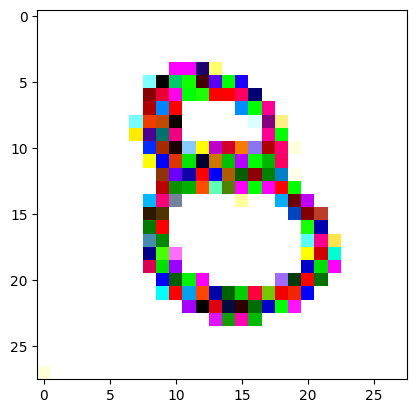

iter 11200 / grad_sum: -0.00012520700693130493, loss: 0.2071794718503952


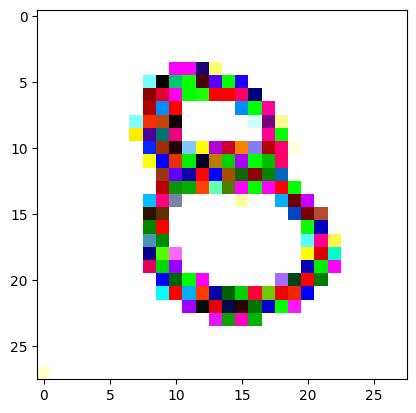

iter 11400 / grad_sum: -0.008496522903442383, loss: 0.22705934941768646


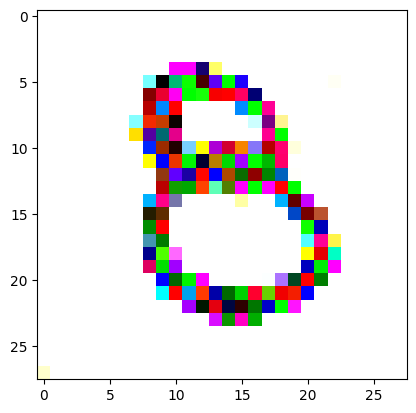

iter 11600 / grad_sum: -0.0059080421924591064, loss: 0.1998962163925171


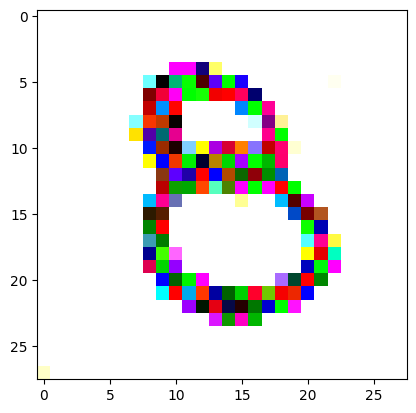

iter 11800 / grad_sum: 0.006994262337684631, loss: 0.20933829247951508


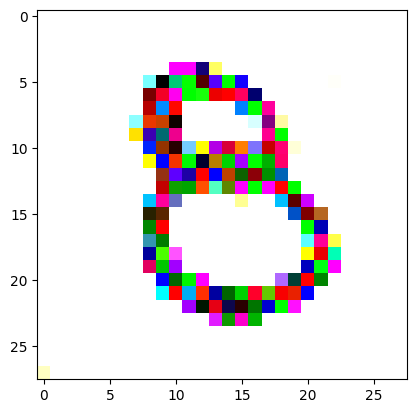

In [8]:
random_sample = get_noisy_starter_tensor()

for i in range(12000):
    vgg_iterate_image(
        random_sample,
        reversed_target_image,
        i,
        update_rate=8.0,
        update_printout=200,
    )
